<span style="font-size: 18px;"><b> А/В тестрование. </span></b>

## Описание проекта

**Цель:** подготовка рекомендаций для увеличения выручки интернет магазина.

**Проект предполагает:**
- подготовку данных,
- проверку достоверности результатов А/В теста,
- статистический анализ результатов.

**Описание данных:**  

**Orders:**  
    `transactionId` — идентификатор заказа;  
    `visitorId` — идентификатор пользователя, совершившего заказ;  
    `date` — дата, когда был совершён заказ;  
    `revenue` — выручка заказа;  
    `group` — группа A/B-теста, в которую попал заказ.  
    
**Visitors:**  
    `date` — дата;  
    `group` — группа A/B-теста;  
    `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

## Загрузка данных, знакомство

### Импорт библиотек, загрузка

In [164]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [165]:
#формат вещественных чисел в таблицах
pd.set_option('display.float_format', '{:.2f}'.format)

#разрешение графиков получше
%config InlineBackend.figure_format = 'retina'

#убираем ворнинги
import warnings
warnings.filterwarnings("ignore")

Загружаем. Даты сразу в нормальном формате. Колонки переименовываем удобно.

In [166]:
orders = pd.read_csv('.../a_b_orders.csv', parse_dates=['date'])
orders.columns = orders.columns.str.replace('Id', '_id')

In [167]:
visitors = pd.read_csv('.../a_b_visitors.csv', parse_dates=['date'])

### Предобработка

Проверим, что с данными всё нормально - пустоты, дубликаты, аномальные значения.

In [168]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [169]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [170]:
orders.duplicated().sum() + visitors.duplicated().sum()

0

In [171]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [172]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [173]:
orders['date'].agg(['min', 'max'])

min   2019-08-01
max   2019-08-31
Name: date, dtype: datetime64[ns]

In [174]:
visitors['date'].agg(['min', 'max'])

min   2019-08-01
max   2019-08-31
Name: date, dtype: datetime64[ns]

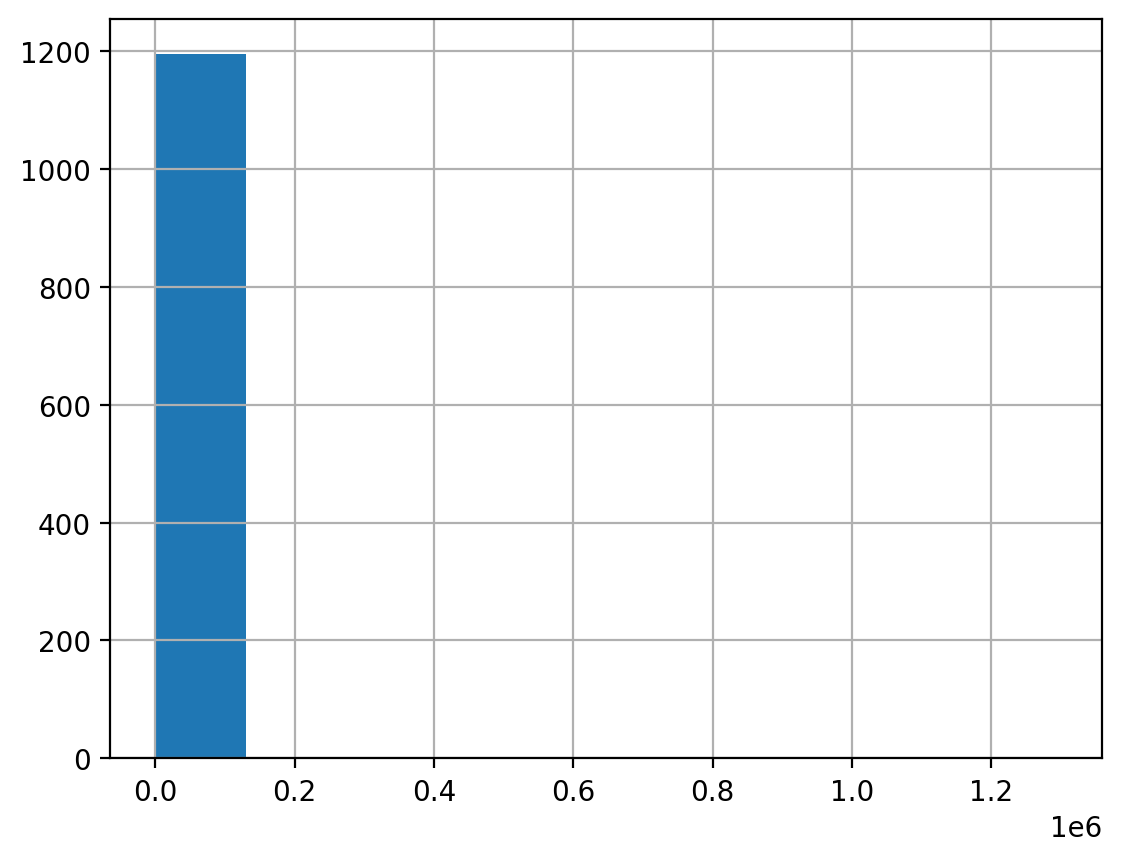

In [175]:
orders['revenue'].hist();

Будут выбросы.  
Пока просто посмотрим поближе.

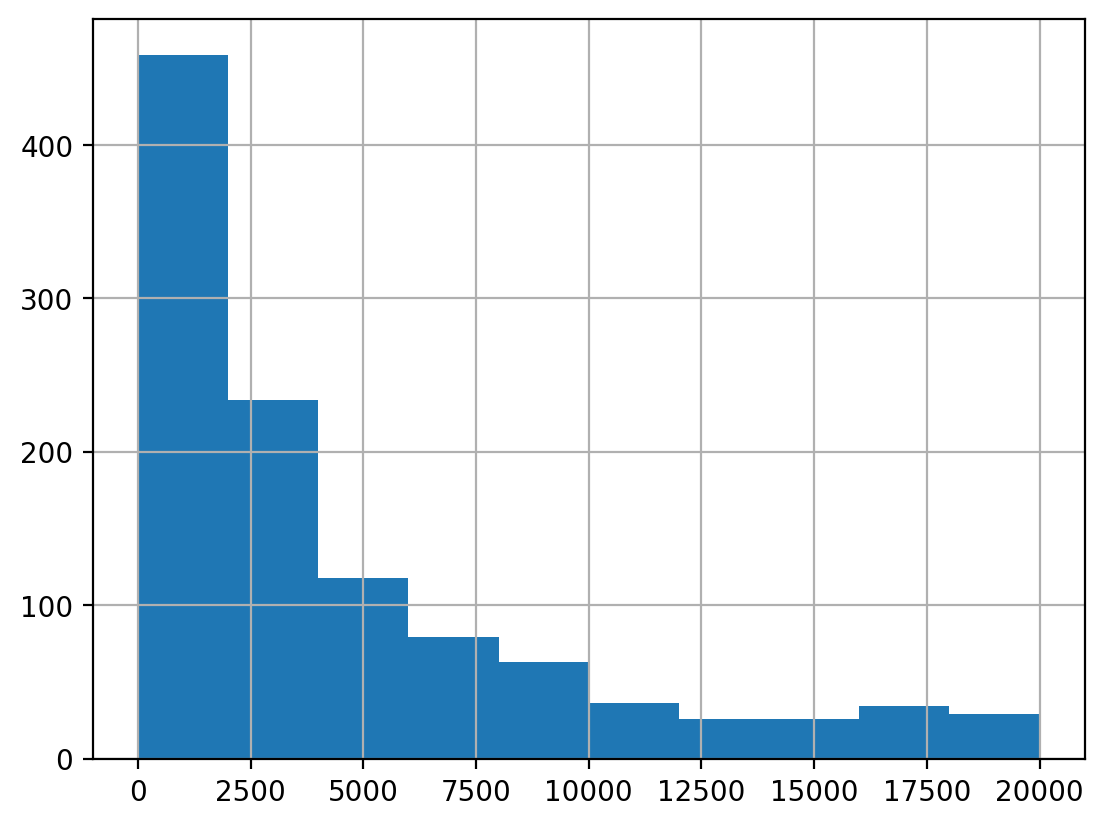

In [176]:
orders['revenue'].hist(range=(0, 20000));

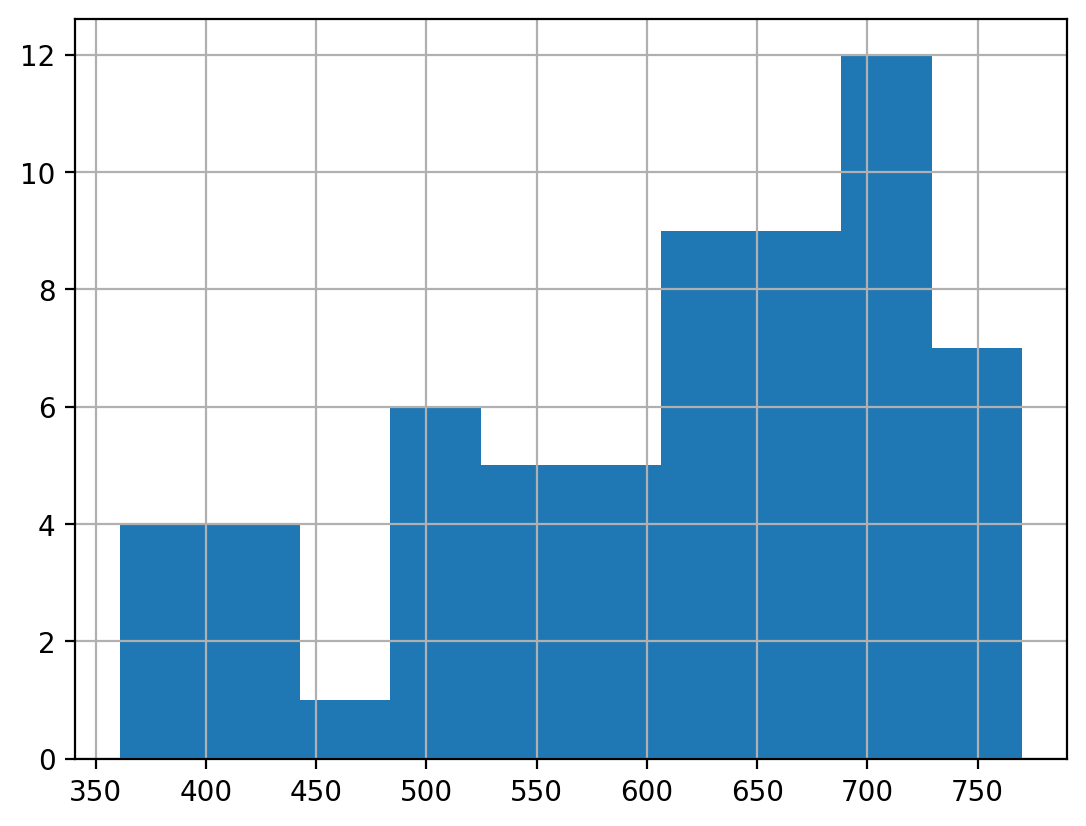

In [177]:
visitors['visitors'].hist();

### Оценка достоверности теста

Проверим, что размеры групп не сильно отличаются.

In [178]:
visitors.groupby('group')['visitors'].sum()

group
A    18736
B    18916
Name: visitors, dtype: int64

Подойдёт.  


Посмотрим, нет ли пользователей, которые попали в обе группы.

In [179]:
ab_users = orders.query('group == "A"').merge(orders.query('group == "B"')
                                   , on='visitor_id'
                                   , suffixes=['_a', '_b'])[['visitor_id', 'date_a', 'date_b']]
ab_users_ = ab_users['visitor_id'].drop_duplicates()
ab_users_.count()

58

In [180]:
ab_users_.count() / orders['visitor_id'].nunique()

0.05625606207565471

58 пользователей (около 6% покупателей).  
Посмотрим, какое количество покупок они совершили.

In [181]:
orders.query('visitor_id in @ab_users_').shape[0]

181

In [182]:
orders.query('visitor_id in @ab_users_').shape[0] / orders.shape[0]

0.15121136173767752

15% покупок совершено некорректно учтёнными пользователями. Это довольно много, но никуда не денешься, эти случайно распределённые между группами покупки будут влиять на корректность результатов, поэтому таких придётся удалять.  
Удалим их из таблицы `orders`, и хотя бы те посещения, в которые они совершали покупки, из таблицы `visitors` (про другие посещения мы просто ничего не знаем, и просто учтём, что они всё-таки остаются влиять на результат).

In [183]:
orders = orders.query('visitor_id not in @ab_users_')

In [184]:
#посчитаем, сколько некорректно учтённых пользователей посчитано в количество посетителей на каждую дату для каждой группы
a_users = ab_users[['visitor_id', 'date_a']].drop_duplicates().groupby('date_a')['visitor_id'].nunique().reset_index()
b_users = ab_users[['visitor_id', 'date_b']].drop_duplicates().groupby('date_b')['visitor_id'].nunique().reset_index()

#добавим столбцы в таблицу с визитами
a_users.columns = ['date', 'a_visitors']
b_users.columns = ['date', 'b_visitors']
a_users['group'] = 'A'
b_users['group'] = 'B'
visitors = visitors.merge(a_users, on=['date', 'group'], how='left').merge(b_users, on=['date', 'group'], how='left')

#вычтем, уберём лишние столбцы
visitors.fillna(0, inplace=True)
visitors['visitors'] = (visitors['visitors'] - visitors['a_visitors'] - visitors['b_visitors']).astype(int)
visitors.drop(['a_visitors', 'b_visitors'], axis=1, inplace=True)

### Выводы  

Имеем данные о ежедневном количестве посетителей и о покупках отдельных посетителей за август 2019 года для групп А и В.  
Предварительной обработки не потребовалось - дубликатов, пустот или очевидных аномалий в данных нет.  
Вероятно потребуется обработка выбросов для `revenue` в таблице `orders`.   

Проверка корректности проведения теста:
 - Размеры групп примерно одинаковые - здесь с тестом всё нормально.  
 - Есть около 6% пользователей, совершивших около 15% покупок, посчитанных в разные группы. Поскольку это влияет на корректность результатов А/В теста, покупки этих пользователей, а так же посещения, о которых нам известно, были удалены из таблиц `orders` и `visitors`, несмотря на то, что это довольно большая доля данных.  
 - В таблице `visitors` всё ещё могут оставаться некорректно учтённые в обе группы посетители, не совершившие покупок в момент посещения. На имеющихся данных невозможно это отследить.  

## Исследовательский анализ

Построим кумулятивную выручку по группам.

In [185]:
cum_revenue_a = orders.query('group == "A"').groupby('date')['revenue'].sum().cumsum()
cum_revenue_b = orders.query('group == "B"').groupby('date')['revenue'].sum().cumsum()

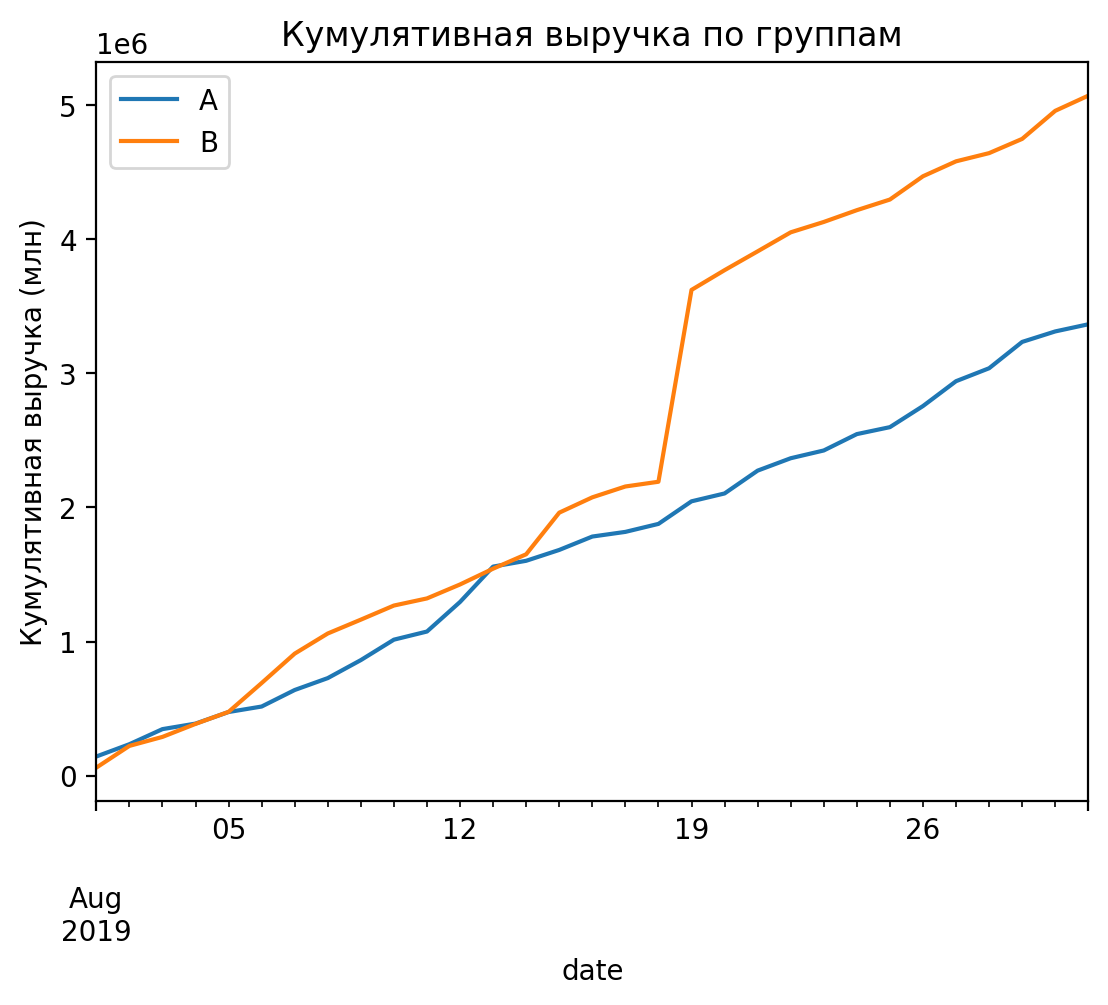

In [186]:
cum_revenue_a.plot(label='A')
cum_revenue_b.plot(label='B')
plt.legend()
plt.title('Кумулятивная выручка по группам')
plt.ylabel('Кумулятивная выручка (млн)')
plt.show()

Похоже, что есть как минимум один очень большой выброс, который затруднит анализ (не совсем очевидно визуально, без него где в итоге окажется линия В - выше А или ниже). Так что прежде, чем продолжать смотреть на графики кумулятивных метрик, посмотрим на выбросы.

### Выбросы

#### Стоимости заказов

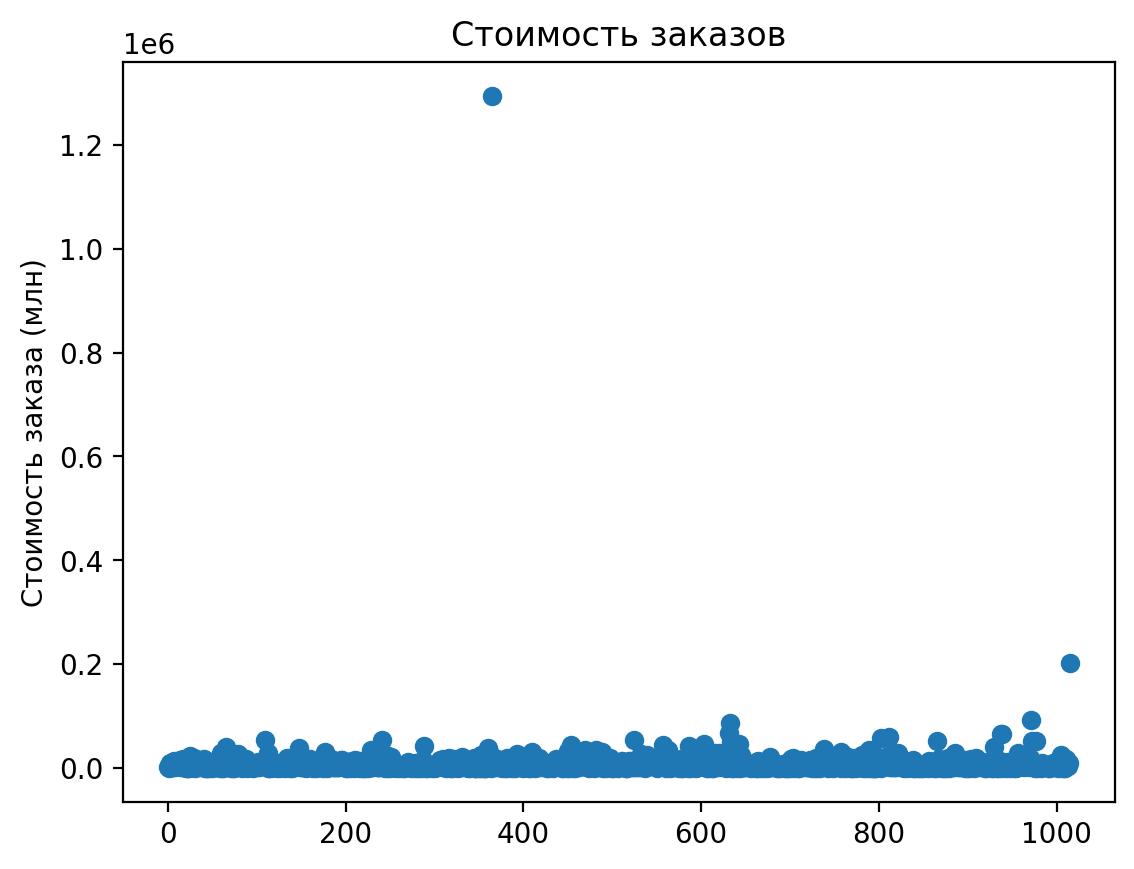

In [187]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов')
plt.ylabel('Стоимость заказа (млн)');

Есть и очевидные выбросы, но всё равно хочется посмотреть поближе.

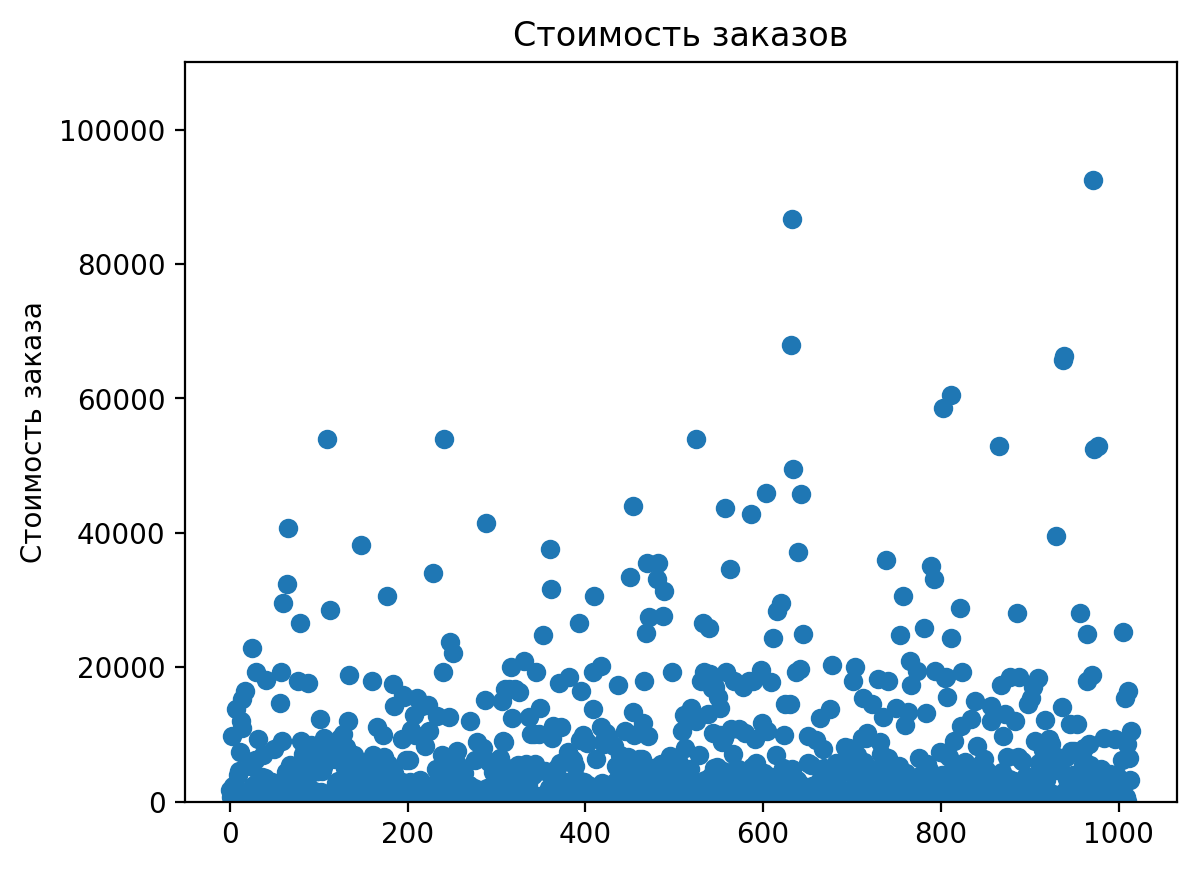

In [188]:
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 110000)
plt.title('Стоимость заказов')
plt.ylabel('Стоимость заказа');

Посмотрим на 0.95 и 0.99 перцентили.

In [189]:
orders['revenue'].quantile([0.95, 0.99])

0.95   26785.00
0.99   53904.00
Name: revenue, dtype: float64

Чтобы не мешали внезапные пользователи, которые приходят и покупают что-нибудь очень дорогое, уберём их из дальнейших расчётов (мы не можем гарантировать, что они так будут делать каждый раз и реально отображают текущее положение вещей для группы).  
Не убираем сразу, пока просто выпишем себе всех таких (по 0.95 перцентилю).

In [190]:
filtered_revenue = orders.query('revenue > 26785')['visitor_id'].unique()

#### Количество заказов на пользователя

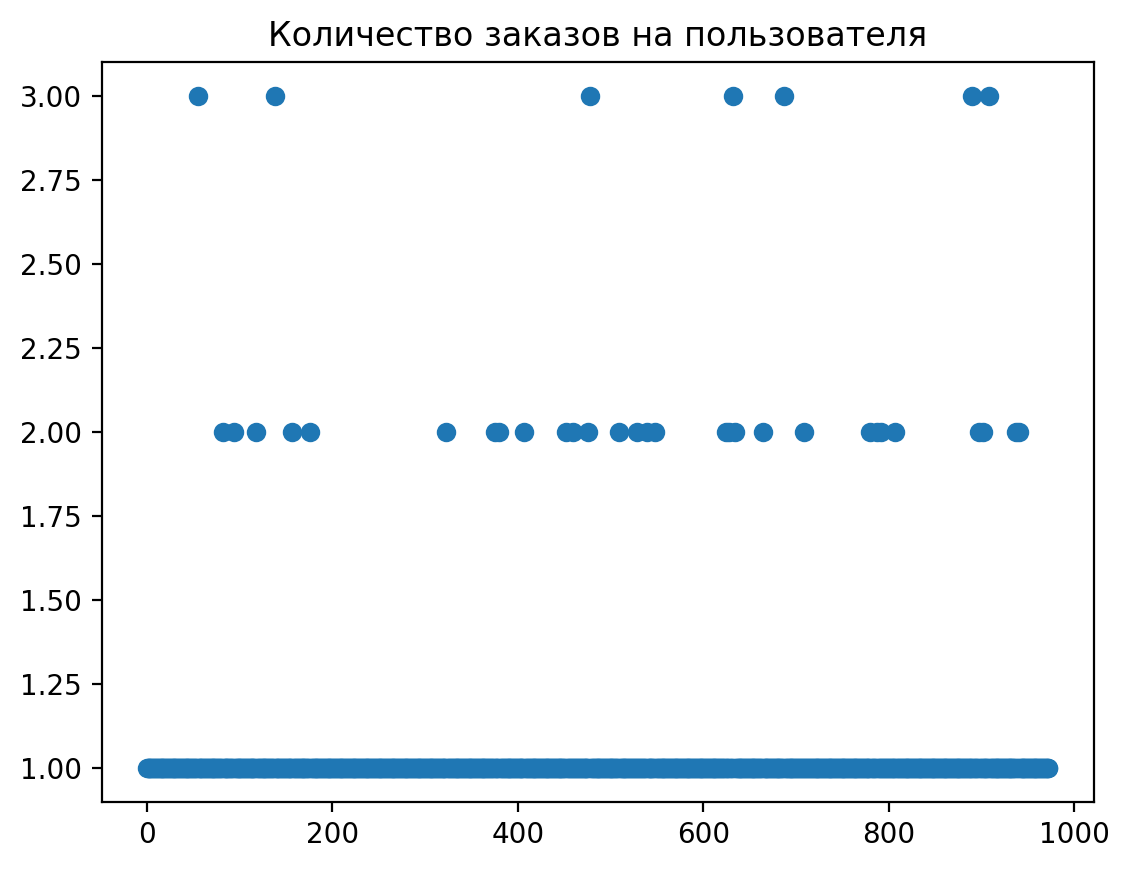

In [191]:
orders_per_buyer = orders.groupby('visitor_id')['revenue'].count()
x_values = pd.Series(range(0, len(orders_per_buyer)))
plt.scatter(x_values, orders_per_buyer)
plt.title('Количество заказов на пользователя');

Здесь не настолько существенные выбросы, чтобы сильно повлиять на что-то. Можно не трогать, но удалим хотя бы тройки - скорее всего, они будут в пределах 0.99 перцентиля, проверим.

In [192]:
orders_per_buyer.quantile([0.95, 0.99])

0.95   1.00
0.99   2.00
Name: revenue, dtype: float64

In [193]:
filtered_orders = orders_per_buyer[orders_per_buyer > 2].index

И соберём для удобной фильтрации в один список пользователей, которые совершали нетипичные действия.

In [194]:
filtered_orders = pd.Series(filtered_orders, name='user_id')
filtered_revenue = pd.Series(filtered_revenue, name='user_id')
filtered_users = pd.concat([filtered_orders, filtered_revenue]).drop_duplicates()

Проверим, какую часть данных мы отфильтруем таким образом.

In [195]:
'{0:.2%}'.format(filtered_users.count() / orders['visitor_id'].nunique())

'5.96%'

6% можно пережить, зато выбросы не будут сбивать.  
Фильтруем и можно смотреть на кумулятивные метрики.

In [196]:
orders = orders.query('visitor_id not in @filtered_users')

### Кумулятивные метрики

#### Кумулятивная выручка по группам

In [197]:
cum_revenue_a = orders.query('group == "A"').groupby('date')['revenue'].sum().cumsum()
cum_revenue_b = orders.query('group == "B"').groupby('date')['revenue'].sum().cumsum()

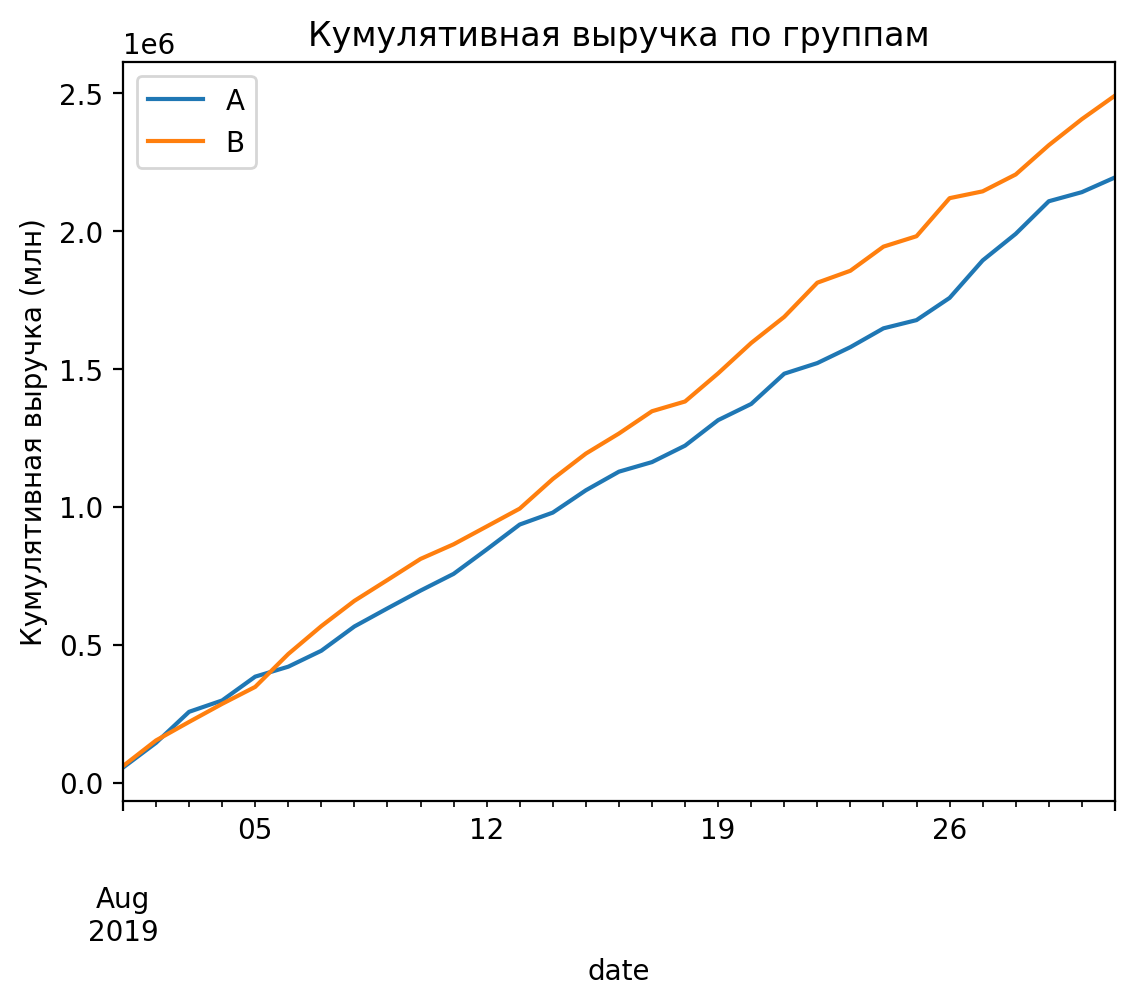

In [198]:
cum_revenue_a.plot(label='A')
cum_revenue_b.plot(label='B')
plt.legend()
plt.title('Кумулятивная выручка по группам')
plt.ylabel('Кумулятивная выручка (млн)')
plt.show()

Ну вот, стало нагляднее. Осталось выяснить, за счёт чего у группы В кумулятивная выручка довольно устойчиво выше.  
Для этого посмотрим что происходит со средним чеком и с количеством покупок на посетителя в каждой группе.

#### Кумулятивный средний чек по группам

In [199]:
avg_revenue_a = orders.query('group == "A"').groupby('date')['revenue'].sum().cumsum() \
                       / orders.query('group == "A"').groupby('date')['revenue'].count().cumsum()

avg_revenue_b = orders.query('group == "B"').groupby('date')['revenue'].sum().cumsum() \
                       / orders.query('group == "B"').groupby('date')['revenue'].count().cumsum()

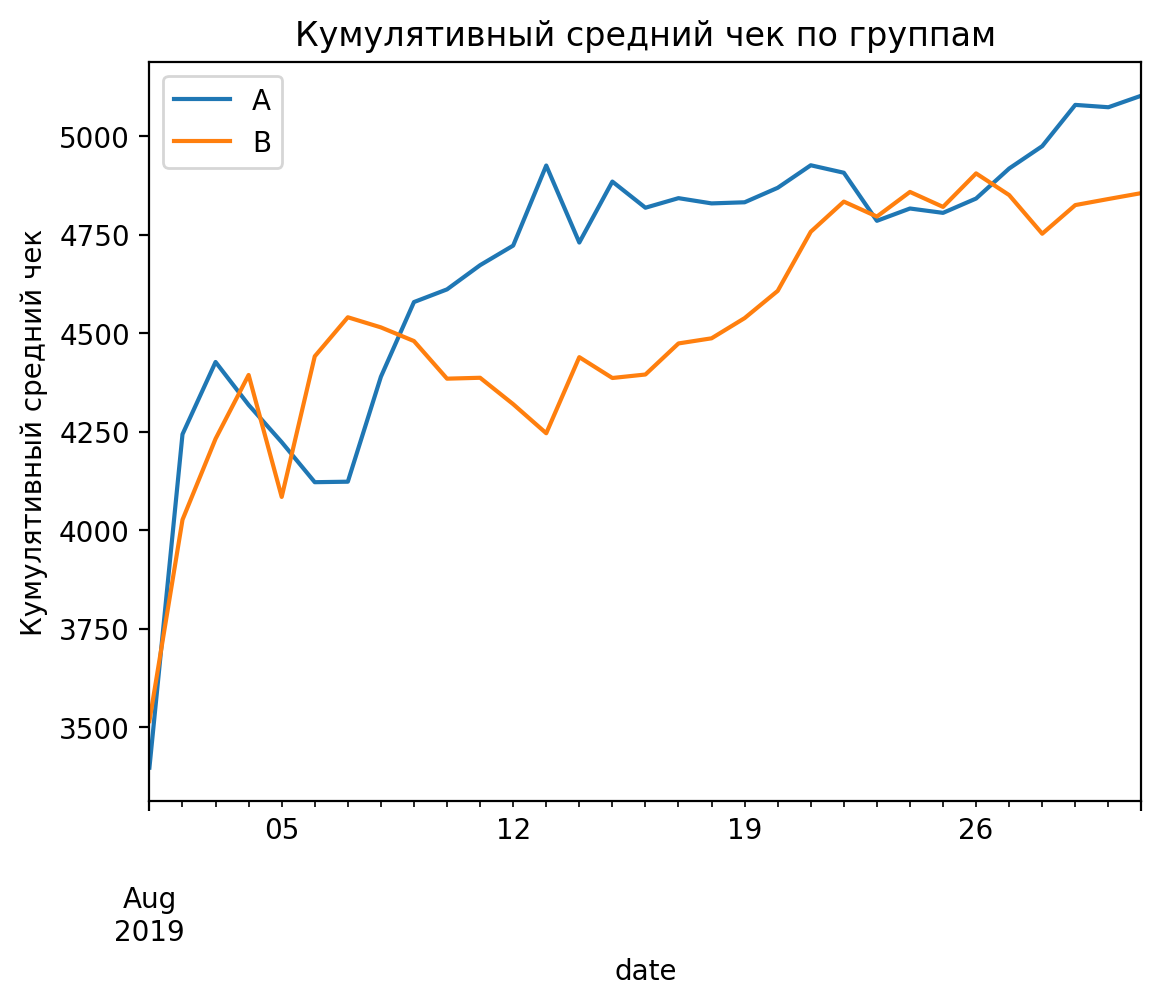

In [200]:
avg_revenue_a.plot(label='A')
avg_revenue_b.plot(label='B')
plt.legend()
plt.title('Кумулятивный средний чек по группам')
plt.ylabel('Кумулятивный средний чек')
plt.show()

Нда. Явно не за счёт среднего чека - здесь надо будет считать, есть ли разница и в пользу какой группы, но пока что результат не выглядит устойчивым.  

Посмотрим на относительное изменение по группе В от А.

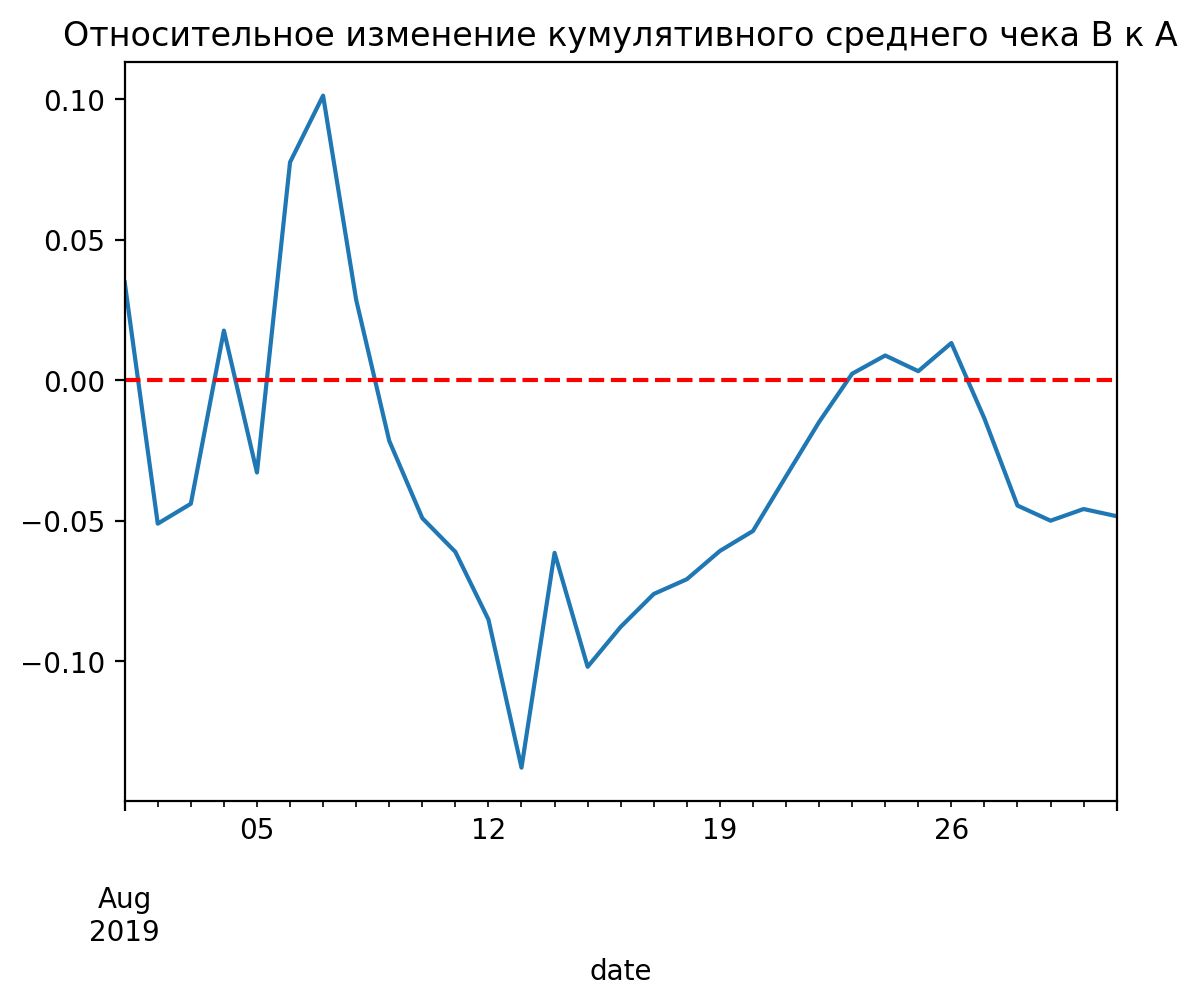

In [201]:
(avg_revenue_b / avg_revenue_a - 1).plot()
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Относительное изменение кумулятивного среднего чека В к А');

Выглядит не очень оптимистично.

#### Кумулятивное среднее количество заказов на посетителя по группам

In [202]:
avg_orders_a = orders.query('group == "A"').groupby('date')['revenue'].count().cumsum() \
               / visitors.query('group == "A"').groupby('date')['visitors'].first().cumsum()

avg_orders_b = orders.query('group == "B"').groupby('date')['revenue'].count().cumsum() \
               / visitors.query('group == "B"').groupby('date')['visitors'].first().cumsum()

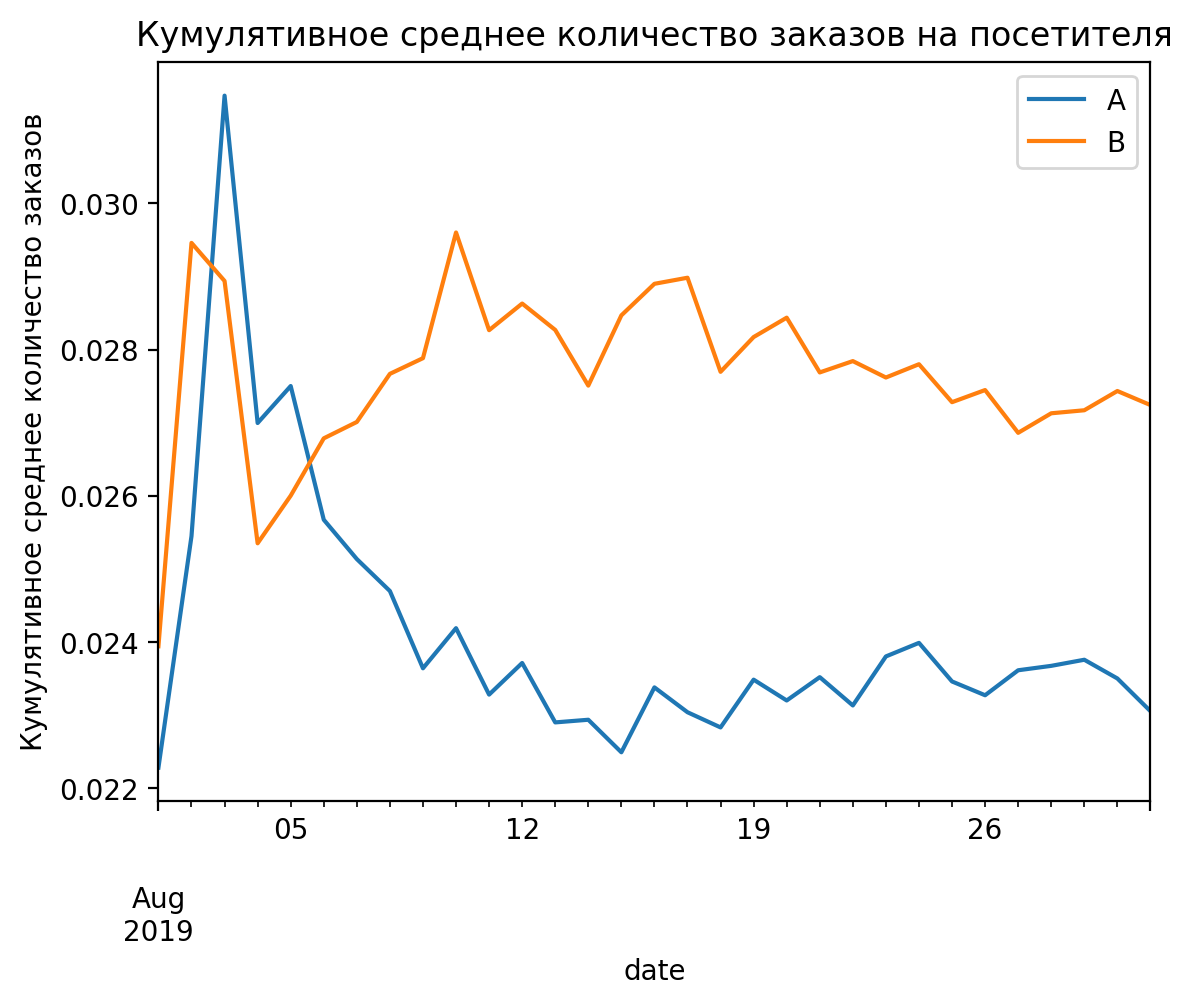

In [203]:
avg_orders_a.plot(label='A')
avg_orders_b.plot(label='B')
plt.legend()
plt.title('Кумулятивное среднее количество заказов на посетителя')
plt.ylabel('Кумулятивное среднее количество заказов')
plt.show()

Вот за счёт среднего количества заказов, похоже, кумулятивная выручка у группы В и выше: результат выше и выглядит довольно устойчиво.  

По относительному изменению кумулятивного среднего количества заказов на посетителя В к А даже виднее.

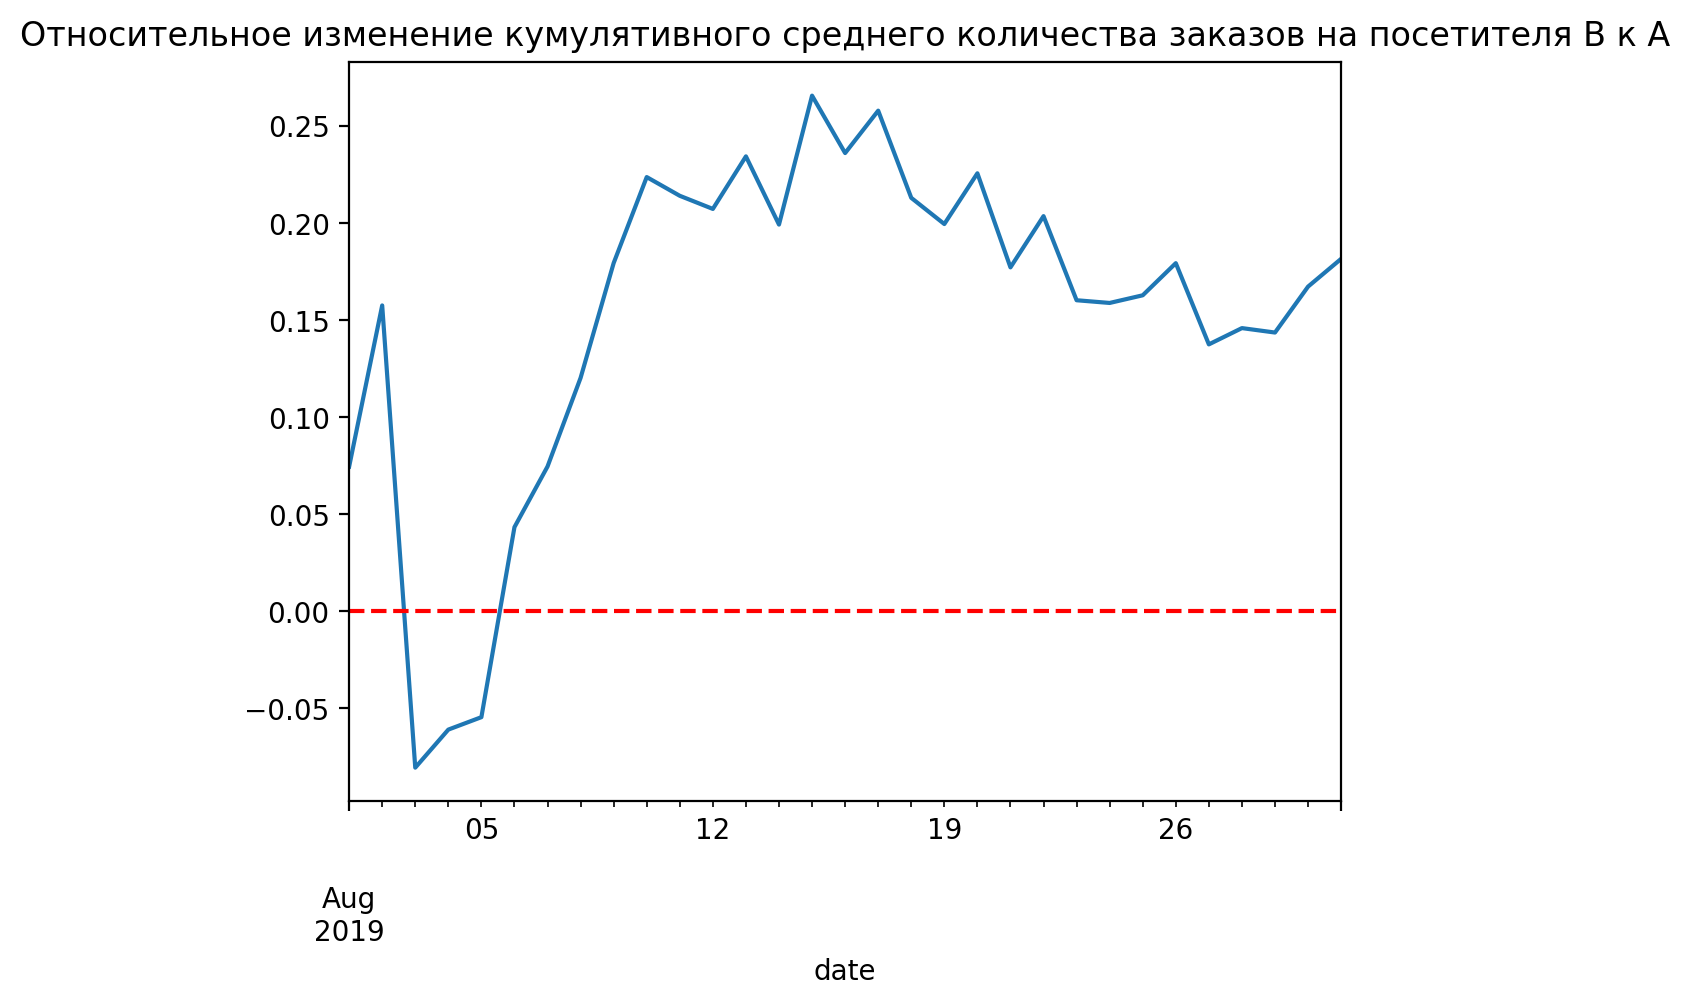

In [204]:
(avg_orders_b / avg_orders_a - 1).plot()
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя В к А');

## Статистический анализ

#### Среднее количество заказов на посетителя.

Готовим выборки для сравниния.

In [205]:
#считаем количество заказов на каждого покупателя
raw_sample_a = orders.query('group == "A" and visitor_id not in @filtered_users').groupby('visitor_id')['revenue'].count()
#создаём данные из списка нулей для каждого ничего не купившего посетителя
non_buyers = pd.Series(0, np.arange(0, visitors.query('group == "A"')['visitors'].sum() - len(raw_sample_a)))
#собираем всё вместе
sample_a = pd.concat([raw_sample_a, non_buyers])

#повторяем то же самое для группы В
raw_sample_b = orders.query('group == "B" and visitor_id not in @filtered_users').groupby('visitor_id')['revenue'].count()
non_buyers = pd.Series(0, np.arange(0, visitors.query('group == "B"')['visitors'].sum() - len(raw_sample_b)))
sample_b = pd.concat([raw_sample_b, non_buyers])

Возьмём манна-уитни, с альфой = 0.05.  
  
**Нулевая гипотеза:** статистически значимой разницы между выборками нет.   
**Альтернативная гипотеза:** между выборками есть статистически значимая разница и у выборки В в распределении более высокие значения, чем у выборки А.

In [206]:
st.mannwhitneyu(sample_a, sample_b, alternative='less').pvalue

0.006267882559932594

Отвергаем нулевую гипотезу в пользу того, что разница между выборками статистически значима, и у группы В результаты получше.  
Посмотрим, на сколько получше.

##### Доверительный интервал

Найдём аналитически.

In [207]:
#точечная оценка
p_est = sample_b.mean() - sample_a.mean()

#стандартные отклонения и размеры выборок
std_a, std_b = sample_a.std(), sample_b.std()
n_a, n_b = sample_a.shape[0], sample_b.shape[0]

#погрешность
z = st.t.ppf(0.975, n_a + n_b -2)
moe = z * (std_a**2 / n_a + std_b**2 / n_b)**0.5

#интервал в штуках
interval = [p_est - moe, p_est + moe]

#выведем интервал в процентах
'{:.2%}'.format(interval[0] / sample_a.mean()), \
'{:.2%}'.format(interval[1] / sample_a.mean())

('3.99%', '32.31%')

И проверим бутстрапом.

In [208]:
diff_list = []
for i in range(5000):
    a_=np.random.choice(sample_a, len(sample_a), replace=True)
    b_=np.random.choice(sample_b, len(sample_b), replace=True)
    diff = b_.mean() - a_.mean()
    diff_list.append(diff)

interval = np.percentile(diff_list, [2.5, 97.5])

'{:.2%}'.format(interval[0] / sample_a.mean()), \
'{:.2%}'.format(interval[1] / sample_a.mean())

('3.78%', '32.06%')

Получаем довольно близкие значения.  
Окончательный вывод: наблюдаем статистически значимую разницу между группами А и В. С вероятностью 0.95 среднее количество покупок на посетителя для группы В выше на величину от 4% до 32%, чем у группы А.

#### Средний чек заказа

Проверим, что разница размеров выборок не очень большая, и мы можем применить манна-уитни.

In [209]:
orders.query('group == "A"')['revenue'].shape[0]

430

In [210]:
orders.query('group == "B"')['revenue'].shape[0]

513

Подойдёт.  
  
Чисто из любопытства посмотрим, какие там средние у выборок.

In [211]:
orders.groupby('group')['revenue'].mean()

group
A   5102.51
B   4855.19
Name: revenue, dtype: float64

In [212]:
st.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'], alternative='less').pvalue

0.6771379686919401

Средний чек у выборки В меньше, но тест манна-уитни говорит, что статистически разница незначима.

## Выводы

Для исследования имелись данные тестирования за полный месяц - август 2019.  
Предобработка не требовалась: дубликаты, пропуски, аномалии отсутствовали.  
Удалены выбросы: около 6% посетителей, совершивших нетипичное количество покупок или очень крупные покупки.  

Проверка корректности проведения теста:
 - Размеры групп примерно одинаковые - здесь с тестом всё нормально.  
 - Есть около 6% покупателей, совершивших около 15% заказов, учтённых в обе группы за период тестирования. Поскольку это влияет на достоверность результатов А/В теста, покупки этих пользователей, а так же посещения, о которых нам известно, были удалены из таблиц `orders` и `visitors`, несмотря на то, что это довольно большая доля данных.  
   
Рекомендация: всё-таки хорошо бы перепроверить данные из таблицы `visitors`. Нам удалось почистить таблицу `orders` и частично таблицу `visitors` от недостоверных результатов А/В теста, но в таблице `visitors` всё ещё в неизвестной нам пропорции могут оказаться учтёнными в разные группы пользователи, которые не были покупателями. Если почистить данные от этих некорректных результатов, то это не повлияет на средний чек, а вот количество заказов на посетителя может измениться.

**Результаты статистических тестов** говорят о том, что:  
- между группами есть статистически значимая разница в количестве заказов на посетителя, в пользу группы В (с вероятностью 0.95 среднее количество покупок на посетителя для группы В выше на величину от 4% до 32%, чем у группы А),
- между группами нет статистически значимой разницы в среднем чеке на покупателя.  

Результат уже какое-то время держится довольно устойчиво.

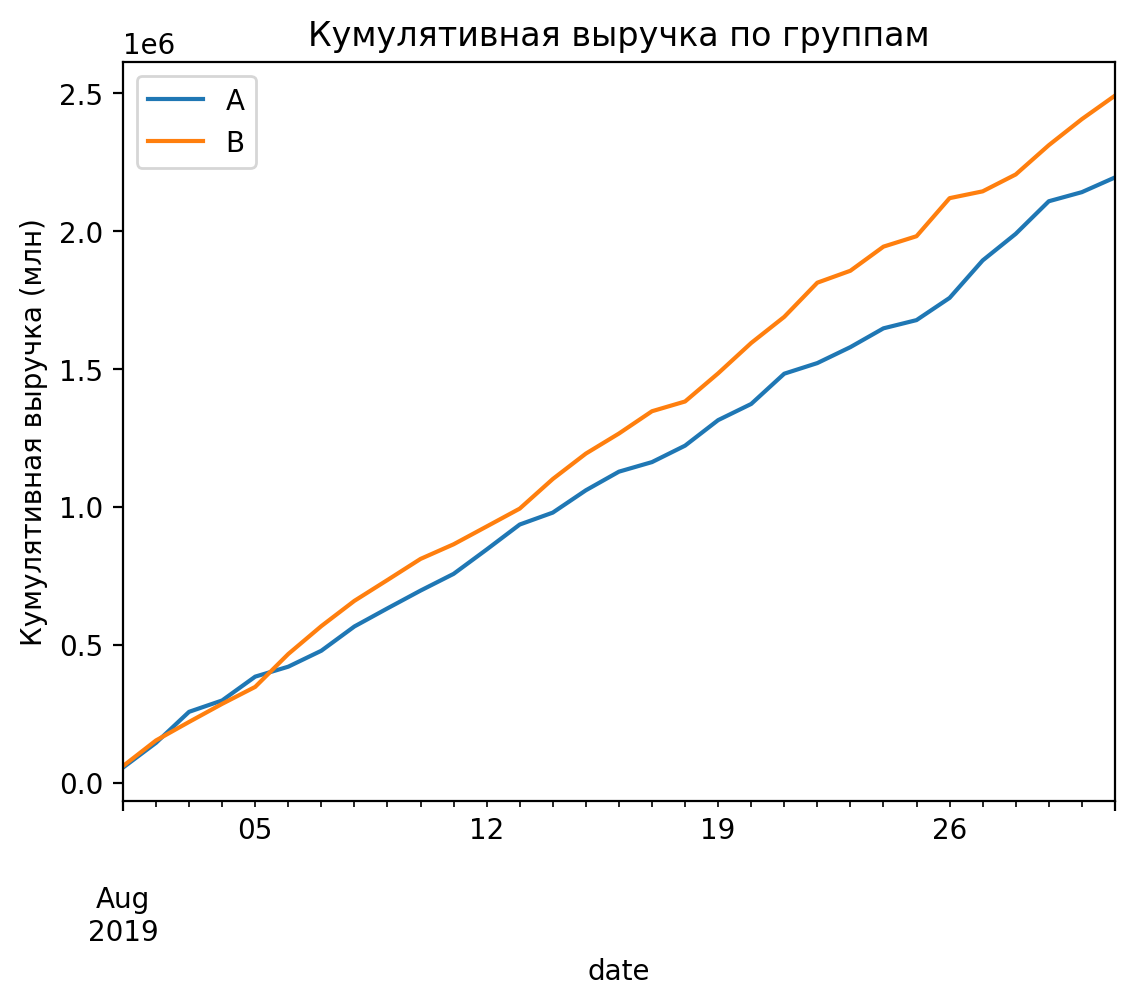

In [213]:
cum_revenue_a.plot(label='A')
cum_revenue_b.plot(label='B')
plt.legend()
plt.title('Кумулятивная выручка по группам')
plt.ylabel('Кумулятивная выручка (млн)')
plt.show()

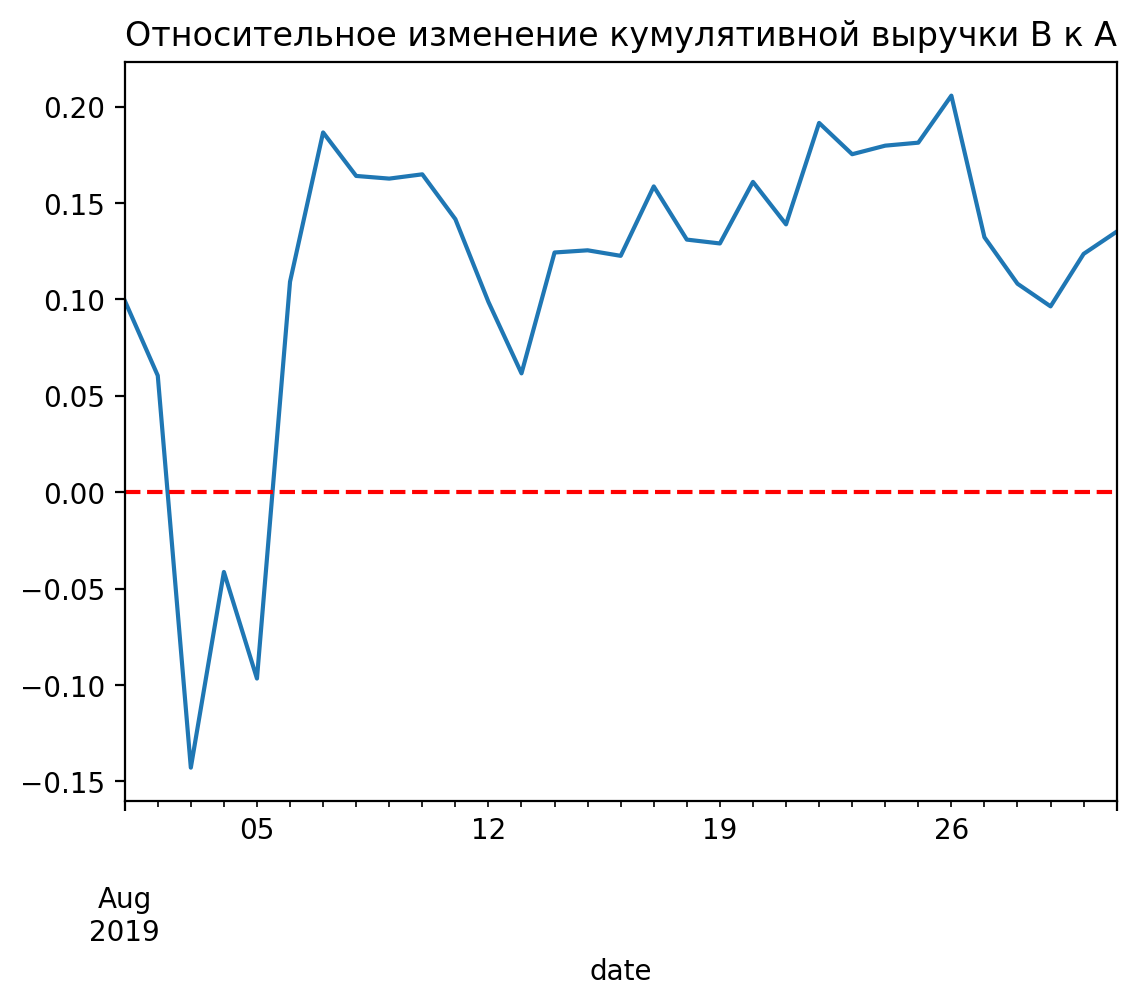

In [214]:
(cum_revenue_b / cum_revenue_a - 1).plot()
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Относительное изменение кумулятивной выручки В к А');